<a href="https://colab.research.google.com/github/changsin/MIU_ML/blob/main/notebooks/11.neural_network_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Writing a neural network from scratch

   Machine Learning libraries like TensorFlow and PyTorch all have excellent ways of creating and training a model so you do not need to write your own neural network from scratch. However, writing a neural network gives you a solid understanding of how Deep Learning works because as complicated as the latest models might appear, the basic building blocks of all neural networks are simple artificial neural networks. The exercise will also equip you with better debugging skills for root causing problems with your models.

   In the following exercise, let's take a simple neural network with a single hidden layer with four nodes and examine the steps in training it.


## How to train a neural network
Training a neural network consists of four steps:

1. Calculate the activation
2. Apply non-linearity
3. Calculate the loss
4. Backpropagate the errors

Let's take each step in more detail.

### 1. Activation

The activation function applies some weights on the input data and add some bias. 

Z = Wx + b
(W: weights x: input, b: bias)

### 2. Apply non-linearity
Let's use sigmoid for applying the non-linearity.

A = sigmoid(Z)

$$ A= f(\theta) = \frac{1}{1 + e^{z}} = \frac{1}{1 + e^{-\theta x}} $$

Note that there are many other non-linearity functions like tanh or relu. These are called 'activation functions' and often dented as 'A' (matrix)

### 3. Cost
The cost or the loss is the difference between the predicted and the actual (ground truth) target values. In our case, we are using MSE (Mean Squared Error) which is a quadratic function with a nice convex shape as illustrated below. The gradient descent operation will help us find the minimum cost.

$$ C = \frac{1}{N}\Sigma_{i=1}^{N} (\hat Y - Y)^2 $$

$\hat Y$: predicted values

$Y$: ground truth

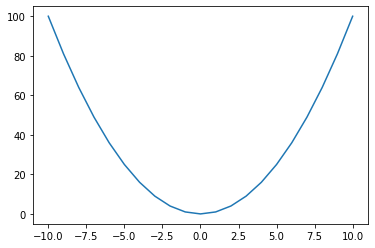

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X = np.arange(-10, 11, 1)
Y = X**2
Y
plt.plot(X, Y)


### 4. Backpropagate

Since the gradient points to the highest peak at the tangent line, you have to take the negative of the gradient and propagate the errors backward starting from the outer most layer.

Mathematically, this can be done by calculating the Jacobian (a vector of partial derivatives) against the cost function. Since there are two variables (parameters) W (weights) and b (bias), you have to calculate the partial derivatives against the cost function C for each.




$$ \mathbf{J}_{\mathbf{W}^{(2)}} = \frac{\partial C}{\partial \mathbf{W}^{(2)}} $$
$$ \mathbf{J}_{\mathbf{b}^{(2)}} = \frac{\partial C}{\partial \mathbf{b}^{(2)}} $$


We cannot take a partial derivate on the cost function directly because there is no weight variable. Instead, we can apply the chain rule to calculate the partial derivatives.

For the weight:
$$\large \frac{\partial C}{\partial \mathbf{W}^{(2)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(2)}}
   \frac{\partial \mathbf{a}^{(2)}}{\partial \mathbf{z}^{(2)}}
   \frac{\partial \mathbf{z}^{(2)}}{\partial \mathbf{W}^{(2)}}
$$

For the bias:
$$\large \frac{\partial C}{\partial \mathbf{b}^{(2)}} =
   \frac{\partial C}{\partial \mathbf{a}^{(2)}}
   \frac{\partial \mathbf{a}^{(2)}}{\partial \mathbf{z}^{(2)}}
   \frac{\partial \mathbf{z}^{(2)}}{\partial \mathbf{b}^{(2)}}
$$


Below is the full code that implements the formulae. It was written for illustration purposes without concerns about brevity or optimization.

## Implementation

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def d_sigmoid(z):
    # derivative of the sigmoid funciton
    return sigmoid(z) * (1.0 - sigmoid(z))

class TwoLayerNetwork:
  def __init__(self, input_size, hidden_size, output_size):
    self.weights1 = np.random.rand(hidden_size, input_size)
    self.weights2 = np.random.rand(output_size, hidden_size)
    self.bias1 = np.random.rand(hidden_size, 1)
    self.bias2 = np.random.rand(output_size, 1)

    # outputs from each layer - the output of the activation function
    self.a1 = np.random.rand(hidden_size)
    self.a2 = np.random.rand(output_size)

    # activations for each layer
    self.z1 = np.random.rand(hidden_size)
    self.z2 = np.random.rand(output_size)

  def activate(self, z):
    return sigmoid(z)

  def d_activate(self, z):
    # derivative of the activation funciton
    return d_sigmoid(z)

  def loss(self, y_true, y_pred):
    # the loss function is squared error
    return ((y_pred - y_true) ** 2).mean()
  
  def predict(self, x):
    return self.forward_pass(x)

  def fit(self, x, y, epoch=10):
    costs = list()
    for e in range(epoch):
      y_pred = self.forward_pass(x)
      self.backward_pass(x, y, y_pred)

      cost = self.loss(y, y_pred)
      costs.append(cost)

    return costs
  
  def forward_pass(self, x):
    # input to the activation function
    self.z1 = np.dot(self.weights1, x.T)
    self.a1 = self.activate(self.z1)

    # hidden to output layer
    self.z2 = self.weights2.dot(self.a1) + self.bias2
    self.a2 = self.activate(self.z2)
    return self.a2

  def backward_pass(self, x, y, y_pred):
    # application of the chain rule on
    # dC/dA2 * dA2/dZ2 * dZ2/dW2
    # C = (Y_pred - Y)**2
    # dC/dA2 = 2 * (A - Y)
    d_cost = 2 * (y_pred - y)
    # A2 = activate(Z2) = sigmoid(Z2)
    # dA2/dZ2 = d_activate(Z2) = d_sigmoid(Z2)
    d_a2 = self.d_activate(self.z2)

    # Z2 = W2.A1 + b2
    # dZ2/dW2 = A1 - output from the hidden layer
    d_z2 = self.a1
    # this value is used again so save it as a separate variable
    d_delta2 = d_cost * d_a2

    # Now assign the delatas to update for the weights and biases
    d_weights2 = np.dot(d_delta2, d_z2.T)
    # since dz/db = 1 
    d_bias2 = np.sum(d_delta2, axis=1, keepdims=True)/x.shape[0]
    
    # propagate to the next layer
    d_prev = np.dot(self.weights2.T, d_delta2)
    d_delta1 = d_prev * self.d_activate(self.a1)
    d_weights1 = np.dot(d_delta1, x)
    d_bias1 = np.sum(d_delta1, axis=1, keepdims=True)/x.shape[0]

    # now update the weights and biases
    self.weights2 = self.weights2 - d_weights2
    self.weights1 = self.weights1 - d_weights1

    self.bias2 = self.bias2 - d_bias2
    self.bias1 = self.bias1 - d_bias1

## Training Data
For the training data, let's use XOR (exclusive-or) data.

In [ ]:
X = np.array([[1, 1],
              [1, 0],
              [0, 1],
              [1, 1]])
Y = np.array([1, 0, 0, 1])
sample_x = np.array([[1, 0]])
X.shape

(4, 2)

## Test
Let's take the default epoch as the training iteration and predict one value at the end.

prediction: [[0.57771776 0.43766229 0.48259321 0.57771776]]


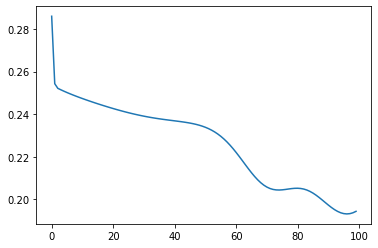

In [ ]:
INPUT_SIZE = 2
HIDDEN_SIZE = 4
OUTPUT_SIZE = 1
EPOCH = 100

nn = TwoLayerNetwork(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

errors = nn.fit(X, Y, EPOCH)

p = nn.predict(X)
print("prediction: {}".format(p))

plt.plot(range(EPOCH), errors)

## MNIST Data
The same network can be used for training other types of data. The following code is a slight modification from
[adeveloperdiary](http://www.adeveloperdiary.com/data-science/machine-learning/understand-and-implement-the-backpropagation-algorithm-from-scratch-in-python/?unapproved=3289&moderation-hash=e30be44173f13aab3600e3f6a1396ba6#comment-3289)

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
# import datasets.mnist.loader as mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pylab as plt

def get_binary_dataset():
    # train_x_orig, train_y_orig, test_x_orig, test_y_orig = mnist.get_data()
    (train_x_orig, train_y_orig), (test_x_orig, test_y_orig) = mnist.load_data()
 
    index_5 = np.where(train_y_orig == 5)
    index_8 = np.where(train_y_orig == 8)

    index = np.concatenate([index_5[0], index_8[0]])
    np.random.seed(1)
    np.random.shuffle(index)
  
    train_y = train_y_orig[index]
    # train_x = train_x_orig[index]
    # print(type(train_x_orig))
    train_x = np.array([train_x_orig[id].flatten() for id in index])
    # train_x = np.array(train_x)
    # print("{} {}".format(train_x.shape, train_x))
 
    train_y[np.where(train_y == 5)] = 0
    train_y[np.where(train_y == 8)] = 1
 
    index_5 = np.where(test_y_orig == 5)
    index_8 = np.where(test_y_orig == 8)
 
    index = np.concatenate([index_5[0], index_8[0]])
    np.random.shuffle(index)
 
    test_y = test_y_orig[index]
    # test_x = test_x_orig[index]
    test_x = np.array([test_x_orig[id].flatten() for id in index])
 
    test_y[np.where(test_y == 5)] = 0
    test_y[np.where(test_y == 8)] = 1
 
    return train_x, train_y, test_x, test_y
 
def pre_process_data(train_x, test_x):
    # Normalize
    train_x = train_x / 255.
    test_x = test_x / 255.
 
    return train_x, test_x
 
 
train_x, train_y, test_x, test_y = get_binary_dataset()

train_x, test_x = pre_process_data(train_x, test_x)


In [ ]:
INPUT_SIZE = 784
HIDDEN_SIZE = 4
OUTPUT_SIZE = 1
nn = TwoLayerNetwork(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

errors = nn.fit(train_x, train_y)
nn.predict(np.array(test_x[0:1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


array([[0.]])